# Testing impact of using diverse conformers
## Introduction
In this experiment, we focus at conformers. There is a lot of things to look at here:
1. Does the starting conformation impact the quality of the prediction?
2. Can we use multiple conformers in the training set as data augmention to yield better predictions?
Our goal here is to start from as diverse conformers as possible, with a maximum of five starting conformers per molecule. We might later extend this to more.


- md_experiment_uuid: e0f120fb-efa9-4c88-a964-e7b99253027c
- mdfp_experiment_uuid: fc57851e-b654-4338-bcdd-faa28ec66253

### Import packages and data

In [2]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
import os
import json
import uuid

import rdkit
print(rdkit.__version__)
import lwreg
from lwreg import standardization_lib
from lwreg import utils
import psycopg2
import pandas as pd
import psycopg2
hostname = 'scotland'
dbname = 'cs_mdfps'
username = 'cschiebroek'


2023.03.3


In [3]:
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()

# Define the SQL query to perform the joins with schema qualification
sql_query = '''
    SELECT cs_mdfps_schema.mdfp_experiment_data.conf_id AS confid,
           public.conformers.molregno,
           cs_mdfps_schema.mdfp_experiment_data.mdfp,
           cs_mdfps_schema.experimental_data.vp
    FROM cs_mdfps_schema.mdfp_experiment_data
    INNER JOIN public.conformers
    ON cs_mdfps_schema.mdfp_experiment_data.conf_id = public.conformers.conf_id
    INNER JOIN cs_mdfps_schema.confid_data
    ON cs_mdfps_schema.mdfp_experiment_data.conf_id = cs_mdfps_schema.confid_data.conf_id
    INNER JOIN cs_mdfps_schema.experimental_data
    ON public.conformers.molregno = cs_mdfps_schema.experimental_data.molregno
    WHERE cs_mdfps_schema.confid_data.confgen_uuid = '906589dd-76fa-4d7b-aa9f-1ee90abe3835'
'''
# Execute the SQL query
cur.execute(sql_query)

# Fetch the results if needed
results = cur.fetchall()
print(f'{len(results)} results fetched')

# Print the column names
column_names = [desc[0] for desc in cur.description]
print(column_names)
confids = [r[0] for r in results]
molregnos = [r[1] for r in results]
mdfps = [json.loads(r[2]['mdfp']) for r in results]
vps = [r[3] for r in results]


3019 results fetched
['confid', 'molregno', 'mdfp', 'vp']


In [4]:
import numpy as np
import xgboost as xgb
X = mdfps
y = vps
params = {
    'max_depth':5,
    'min_child_weight': 5,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
}
train_x = np.array(X)
train_y = np.array(y)
dtrain = xgb.DMatrix(train_x, label=train_y)
model = xgb.train(
    params,
    dtrain,
    num_boost_round=999,
    verbose_eval=False
)

In [124]:
from sklearn.model_selection import KFold
import numpy as np
import tqdm
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from functools import reduce
from scipy.stats import linregress


def getStatValues(x,y):
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    this_rmse = mean_squared_error(np.array(x), np.array(y), squared=False)
    this_mue = mean_absolute_error(np.array(x), np.array(y))
    return slope, intercept, r_value**2, this_rmse, this_mue

### Sanity check: predict on own training data
If the descriptor is not good (say, multiple similar inputs with different output or vice versa), would give non-perfect score

RMSE:  0.0019993056445369913
MAE:  0.001351394480637289
R2:  0.9999996955828648


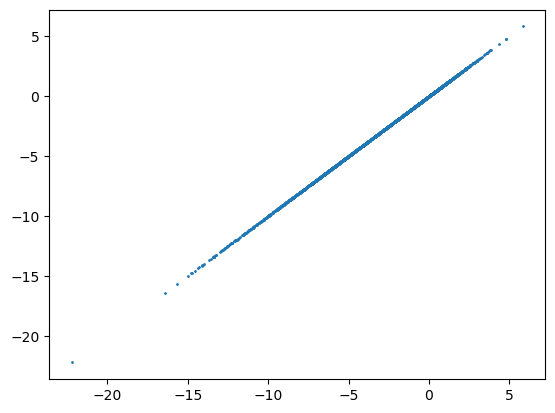

In [125]:
#double check: how does it predict on the training set? should be perfect
preds = model.predict(dtrain)
#get stats and plot
from scipy.stats import pearsonr
slope_mdfp_d, intercept_mdfp_d, r2_train, rmse_train, mae_train = getStatValues(preds, train_y)
print('RMSE: ', rmse_train)
print('MAE: ', mae_train)
print('R2: ', r2_train)
import matplotlib.pyplot as plt
plt.scatter(preds, train_y,s=1)
plt.show()


Perfect predictions on the training set. Lets move on and collect the data from the diverse conformer experiment

In [5]:
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()

# Define the SQL query to perform the joins with schema qualification
sql_query = '''
    SELECT cs_mdfps_schema.mdfp_experiment_data.conf_id AS confid,
           public.conformers.molregno,
           cs_mdfps_schema.mdfp_experiment_data.mdfp,
           cs_mdfps_schema.experimental_data.vp
    FROM cs_mdfps_schema.mdfp_experiment_data
    INNER JOIN public.conformers
    ON cs_mdfps_schema.mdfp_experiment_data.conf_id = public.conformers.conf_id
    INNER JOIN cs_mdfps_schema.confid_data
    ON cs_mdfps_schema.mdfp_experiment_data.conf_id = cs_mdfps_schema.confid_data.conf_id
    INNER JOIN cs_mdfps_schema.experimental_data
    ON public.conformers.molregno = cs_mdfps_schema.experimental_data.molregno
    WHERE cs_mdfps_schema.confid_data.confgen_uuid = '11093a30-b6d0-4e3f-a22b-8dcad60d6a11'
'''
# Execute the SQL query
cur.execute(sql_query)

# Fetch the results if needed
results = cur.fetchall()
print(f'{len(results)} results fetched')

# Print the column names
column_names = [desc[0] for desc in cur.description]
confids = [r[0] for r in results]
molregnos = [r[1] for r in results]
print(f'{len(set(molregnos))} unique molregnos')
mdfps = [json.loads(r[2]['mdfp']) for r in results]
vps = [r[3] for r in results]


11197 results fetched
3008 unique molregnos


Lets look at the performance of the model if we train it on one conformer for all molecules, and predicts on the new conformers we generated

In [127]:
import matplotlib.pyplot as plt

def density_plot(real,prediction,print_stats=True):
    if print_stats:
        slope_mdfp_d, intercept_mdfp_d, r2, this_rmse, this_mae = getStatValues(prediction, real)
        print('RMSE: ', this_rmse)
        print('MAE: ', this_mae)
        print('R2: ', r2)
    fsize = 20
    fig = plt.figure(1, figsize=(10, 6.15))
    ax = plt.subplot(111)
    lower = min(prediction + real) - 2
    upper = max(prediction + real) + 2
    x = np.linspace(lower, upper,100)
    y = slope_mdfp_d*x+intercept_mdfp_d
    plt.plot(x, y, '-r')
    plt.plot([min(prediction + real), max(prediction + real)], [min(prediction + real), max(prediction + real)], 'k-')
    plt.plot([min(prediction + real), max(prediction + real)], [min(prediction + real)-1, max(prediction + real) - 1], 'k--')
    plt.plot([min(prediction + real), max(prediction + real)], [min(prediction + real)+1, max(prediction + real)+1], 'k--')

    import statsmodels.api as sm
    dens_u = sm.nonparametric.KDEMultivariate(data=[prediction, real],var_type='cc', bw='normal_reference')
    z = dens_u.pdf([prediction, real])

    sc = plt.scatter(prediction, real, lw=0, c=z, s=10, alpha = 0.9)

    cbar = plt.colorbar(sc)
    cbar.ax.tick_params(labelsize=fsize)

    plt.ylabel(r'Exp. $\log (VP)$', fontsize=fsize)
    plt.xlabel(r'Predicted $\log (VP)$', fontsize=fsize)
    plt.setp(ax.get_xticklabels(), fontsize=fsize)
    plt.setp(ax.get_yticklabels(), fontsize=fsize)
    plt.grid(1,"both")
    plt.axis([lower, upper, lower, upper])
    plt.tight_layout()
    plt.show()


RMSE:  0.8286129540353928
MAE:  0.5241263666722458
R2:  0.9476049142354924


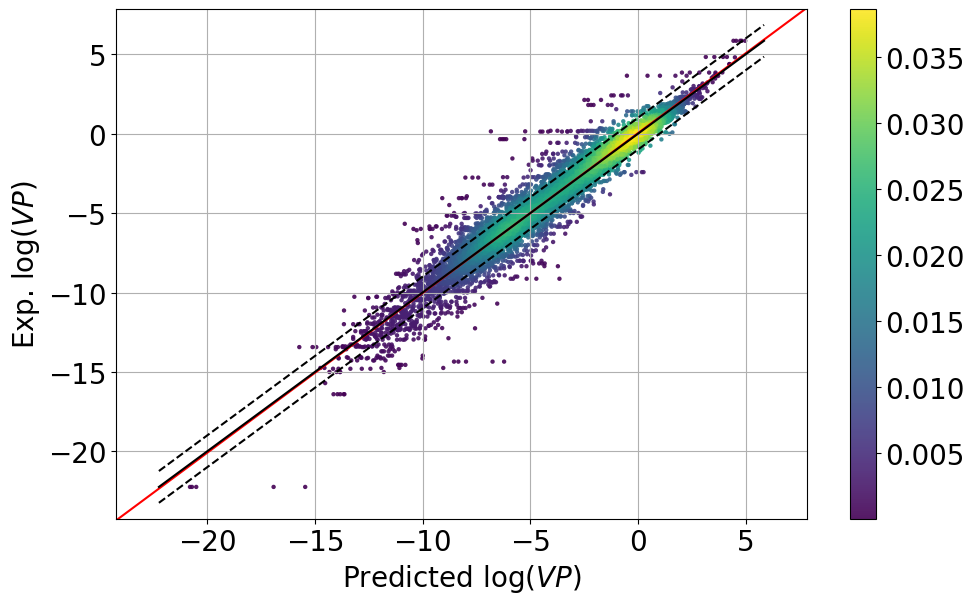

In [128]:
#lets see how it does when presented the same mols, but different conformers:
test_x = np.array(mdfps)
test_y = np.array(vps)
dtest = xgb.DMatrix(test_x, label=test_y)
preds = model.predict(dtest)
prediction = list(preds)
real = list(test_y)
density_plot(real,prediction)

In [129]:
#make table with stats for predict on: same conf, same mol, different mol
same_conf = [rmse_train, mae_train, r2_train]
slope_mdfp_d, intercept_mdfp_d, r2_conf, rmse_conf, mae_conf = getStatValues(prediction, real)
same_mol = [rmse_conf, mae_conf, r2_conf]
different_mol = [1.3868043165371828,0.8605140706266278,0.8527601493708502] #from First_test.ipynb
# create a DataFrame from the three lists
metric_df = pd.DataFrame({'same_conf': same_conf, 'same_mol': same_mol, 'different_mol': different_mol})

# set the index and column names
metric_df.index = ['RMSE', 'MAE', 'R2']
metric_df.columns = ['Same Conformer', 'Same Mol per Conf', 'Different Mol']

# display the resulting DataFrame
metric_df

,Same Conformer,Same Mol per Conf,Different Mol
RMSE,0.001999,0.828613,1.386804
MAE,0.001351,0.524126,0.860514
R2,1.000000,0.947605,0.852760


RMSE:  0.6867962053000242
MAE:  0.4297914964150993
R2:  0.9640066200710269


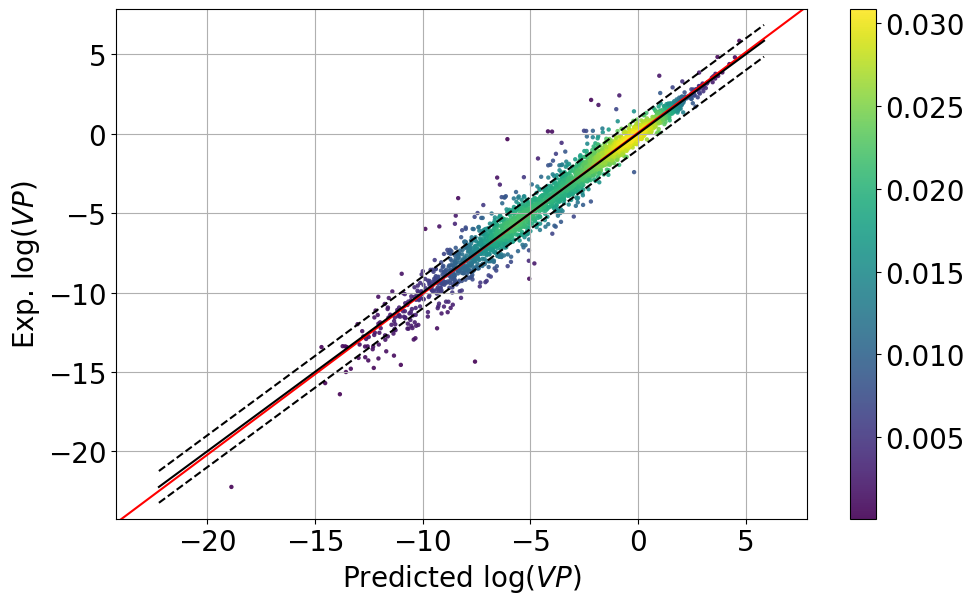

,Same Conformer,Same Mol per Conf,Different Mol,Same Mol Averaged
RMSE,0.001999,0.828613,1.386804,0.686796
MAE,0.001351,0.524126,0.860514,0.429791
R2,1.000000,0.947605,0.852760,0.964007


In [130]:
#also different mol with mean predictions grouped by molregno
vps = real
preds = prediction
df_preds = pd.DataFrame({'vp': vps, 'pred': preds, 'confid': confids, 'molregno': molregnos})
df_preds = df_preds.groupby('molregno').mean()
prediction = df_preds['pred'].tolist()
real = df_preds['vp'].tolist()
density_plot(real,prediction)
slope_mdfp_d, intercept_mdfp_d, r2_fold, rmse_fold, mae_fold = getStatValues(prediction, real)
metric_df['Same Mol Averaged'] = [rmse_fold, mae_fold, r2_fold]
metric_df

Okay, this is somewhat as expected, but nice to confirm: The stats are better then when predicting on new mols, but worse then predicting same conf. 

## Data augmentation
Lets see if we get better predictions on new mols if we have multiple conformers per molecule in both train and test

In [6]:
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()

# Define the SQL query to perform the joins with schema qualification
sql_query = '''
    SELECT cs_mdfps_schema.mdfp_experiment_data.conf_id AS confid,
           public.conformers.molregno,
           cs_mdfps_schema.mdfp_experiment_data.mdfp,
           cs_mdfps_schema.experimental_data.vp
    FROM cs_mdfps_schema.mdfp_experiment_data
    INNER JOIN public.conformers
    ON cs_mdfps_schema.mdfp_experiment_data.conf_id = public.conformers.conf_id
    INNER JOIN cs_mdfps_schema.confid_data
    ON cs_mdfps_schema.mdfp_experiment_data.conf_id = cs_mdfps_schema.confid_data.conf_id
    INNER JOIN cs_mdfps_schema.experimental_data
    ON public.conformers.molregno = cs_mdfps_schema.experimental_data.molregno
'''
# Execute the SQL query
cur.execute(sql_query)

# Fetch the results if needed
results = cur.fetchall()
print(f'{len(results)} results fetched')
data_full = pd.DataFrame(results, columns=['confid', 'molregno', 'mdfp', 'vp'])
#mdfp; load the dict, get only the value for key 'mdfp' and json.loads it
data_full['mdfp'] = data_full['mdfp'].apply(lambda x: json.loads(x['mdfp']))
data_full.head()

14216 results fetched


,confid,molregno,mdfp,vp
0,1150,7,"[9, 5, 0, 0, 0, 0, 0, 0, 0, 0, 7.3614322526332...",-0.301067
1,1151,8,"[13, 1, 0, 2, 0, 0, 0, 0, 0, 0, -97.7987770071...",-6.053323
2,2388,2390,"[10, 1, 0, 0, 0, 0, 0, 0, 0, 0, -24.3637634540...",-0.674795
3,2400,2402,"[10, 2, 2, 0, 0, 0, 0, 0, 0, 0, -13.4724999801...",-3.000000
4,2415,2417,"[15, 4, 1, 1, 0, 0, 1, 2, 0, 0, -174.933858069...",-4.700000


In [132]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold
def train_pred_xgboost(df,params,splits=5):
    gkf = GroupKFold(n_splits=splits)

    # Create an empty list to store the indices of each fold
    fold_indices = []

    # Group the data by 'molregno'
    groups = df['molregno']

    # Iterate over each fold
    for train_idx, test_idx in gkf.split(df, groups=groups):
        fold_indices.append((train_idx, test_idx))

    y = df['vp']  
    params = params
    output = ([],[],[],[])

    # Iterate over each fold
    for fold, (train_idx, test_idx) in enumerate(fold_indices):
        # Split the data into train and test sets for this fold
        X_train = np.array(df['mdfp'].iloc[train_idx].tolist())  # Convert lists to NumPy arrays
        X_test = np.array(df['mdfp'].iloc[test_idx].tolist())
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        molregnos_test = df['molregno'].iloc[test_idx]
        confids_test = df['confid'].iloc[test_idx]
        

        # Create DMatrix for training and testing
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)

        model = xgb.train(
            params,
            dtrain,
            num_boost_round=999,
            evals=[(dtest, "Test")],
            early_stopping_rounds=10,
            verbose_eval=False

        )
        pp = model.predict(dtest)

        output[0].append(y_test)
        output[1].append(pp)
        output[2].append(molregnos_test)
        output[3].append(confids_test)
        rmse = np.sqrt(mean_squared_error(y_test, pp, squared=False))
        print(f"Fold {fold + 1}: RMSE = {rmse}")
    return output


In [133]:
params = {
    'max_depth':5,
    'min_child_weight': 5,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
}
output = train_pred_xgboost(data_full,params)

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 1: RMSE = 1.3822507557697243


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 2: RMSE = 1.1143850244039697


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 3: RMSE = 1.2430200913016198


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 4: RMSE = 1.133774995138647
Fold 5: RMSE = 1.1923293481603332


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


RMSE:  1.5002626238604484
MAE:  0.8953190225482144
R2:  0.8295938426306179


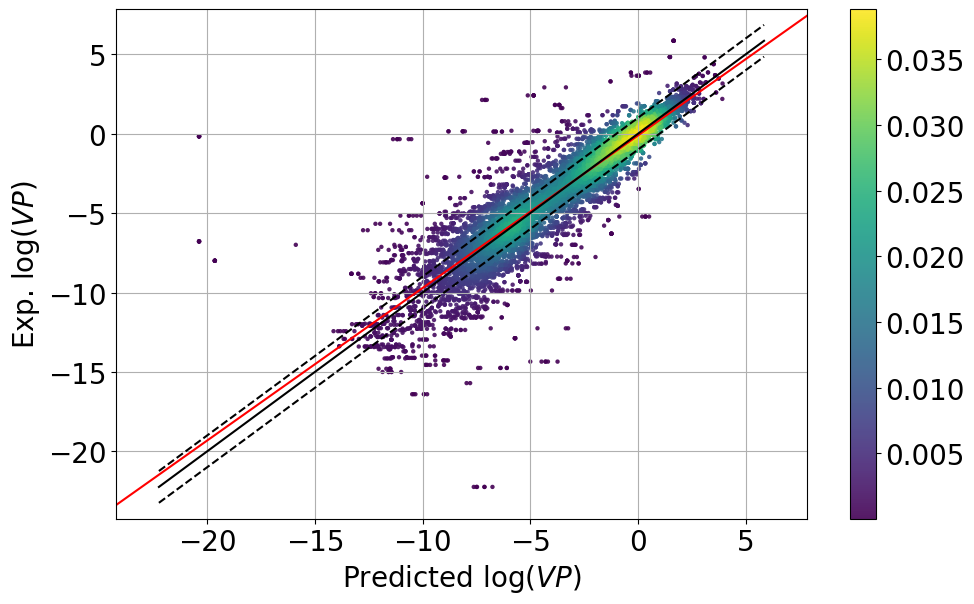

In [134]:
real, prediction = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))
density_plot(real,prediction)

In [135]:
#add these metrics to metric_df
slope_mdfp_d, intercept_mdfp_d, r2_fold, rmse_fold, mae_fold = getStatValues(prediction, real)
metric_df['Augmentation'] = [rmse_fold, mae_fold, r2_fold]
metric_df

,Same Conformer,Same Mol per Conf,Different Mol,Same Mol Averaged,Augmentation
RMSE,0.001999,0.828613,1.386804,0.686796,1.500263
MAE,0.001351,0.524126,0.860514,0.429791,0.895319
R2,1.000000,0.947605,0.852760,0.964007,0.829594


Interesting, this somehow seems worse then what we had before (1 conf per molecule). Maybe we should combine the predictions first to yield one value per mol.

RMSE:  1.4096163304193874
MAE:  0.8378671395454029
R2:  0.8482820862592555


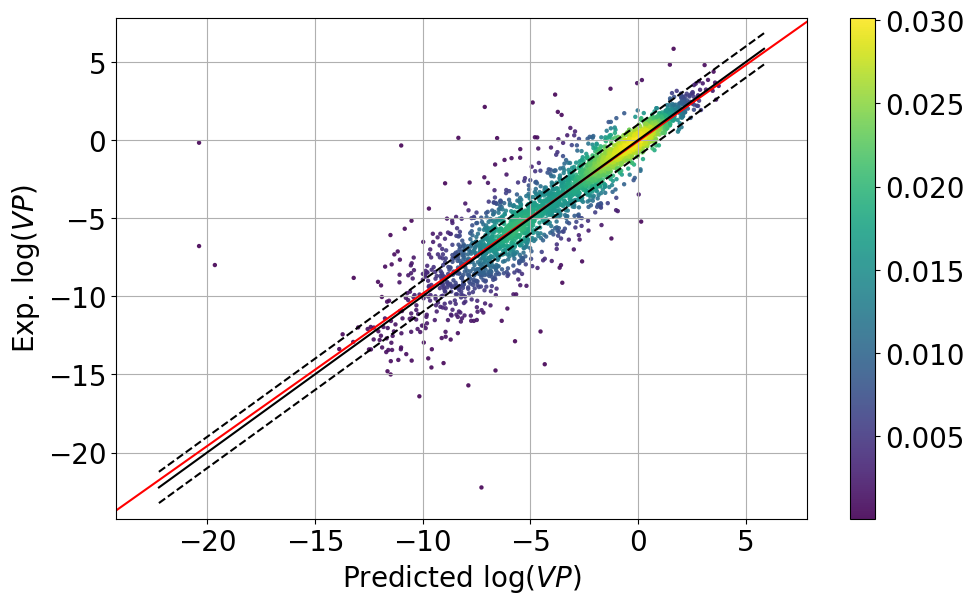

,Same Conformer,Same Mol per Conf,Different Mol,Same Mol Averaged,Augmentation,Augmentation_mean
RMSE,0.001999,0.828613,1.386804,0.686796,1.500263,1.409616
MAE,0.001351,0.524126,0.860514,0.429791,0.895319,0.837867
R2,1.000000,0.947605,0.852760,0.964007,0.829594,0.848282


In [136]:
vps = reduce(lambda a,b : list(a)+list(b) , output[0])
preds = reduce(lambda a,b : list(a)+list(b), output[1])
molregnos = reduce(lambda a,b : list(a)+list(b), output[2])
confids = reduce(lambda a,b : list(a)+list(b), output[3])
df_preds = pd.DataFrame({'vp': vps, 'pred': preds, 'confid': confids, 'molregno': molregnos})
df_preds = df_preds.groupby('molregno').mean()
prediction = df_preds['pred'].tolist()
real = df_preds['vp'].tolist()
density_plot(real,prediction)
slope_mdfp_d, intercept_mdfp_d, r2_fold, rmse_fold, mae_fold = getStatValues(prediction, real)
metric_df['Augmentation_mean'] = [rmse_fold, mae_fold, r2_fold]
metric_df

taking the mean of predictions does make it better, but RMSE and R2 are still worse then before, though there seems to be an improvement in MAE. 

## Hyperparamter tuning
Hyperparameters were screened using 002_HP_opt.py. However, more work should be done on carefully selecting the to-be-tuned parameters, and to run a search for the best ones. Right now we will use the best params found for now.

In [137]:
params = {
    'max_depth':9,
    'min_child_weight': 4,
    'eta':.05,
    'subsample': 1,
    'colsample_bytree': 0.5,
}
output = train_pred_xgboost(data_full,params)

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 1: RMSE = 1.3434724334011732


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 2: RMSE = 1.1109512523742475


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 3: RMSE = 1.2110379137467717


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 4: RMSE = 1.1128012466692743


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 5: RMSE = 1.1884373175732792


RMSE:  1.364706457614459
MAE:  0.7983925809875909
R2:  0.8574307304747472


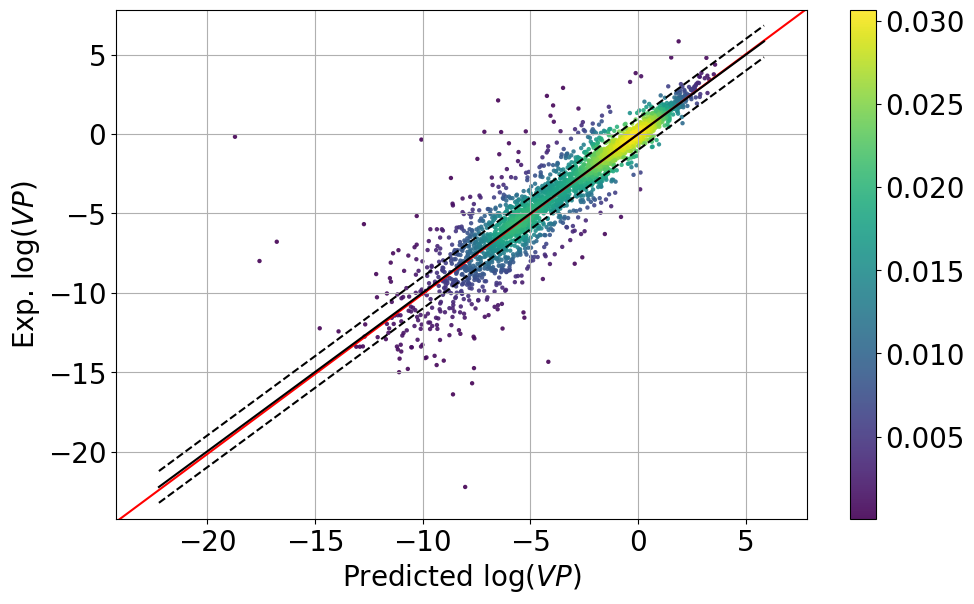

,Same Conformer,Same Mol per Conf,Different Mol,Same Mol Averaged,Augmentation,Augmentation_mean,Augmentation_mean_hp_opt
RMSE,0.001999,0.828613,1.386804,0.686796,1.500263,1.409616,1.364706
MAE,0.001351,0.524126,0.860514,0.429791,0.895319,0.837867,0.798393
R2,1.000000,0.947605,0.852760,0.964007,0.829594,0.848282,0.857431


In [138]:
vps = reduce(lambda a,b : list(a)+list(b) , output[0])
preds = reduce(lambda a,b : list(a)+list(b), output[1])
molregnos = reduce(lambda a,b : list(a)+list(b), output[2])
confids = reduce(lambda a,b : list(a)+list(b), output[3])
df_preds = pd.DataFrame({'vp': vps, 'pred': preds, 'confid': confids, 'molregno': molregnos})
df_preds = df_preds.groupby('molregno').mean()
prediction = df_preds['pred'].tolist()
real = df_preds['vp'].tolist()
density_plot(real,prediction)
slope_mdfp_d, intercept_mdfp_d, r2_fold, rmse_fold, mae_fold = getStatValues(prediction, real)
metric_df['Augmentation_mean_hp_opt'] = [rmse_fold, mae_fold, r2_fold]
metric_df

Lowest RMSE: Same Mol Averaged, 0.69
Lowest MAE: Same Mol Averaged, 0.43
Highest R2: Same Mol Averaged 0.96


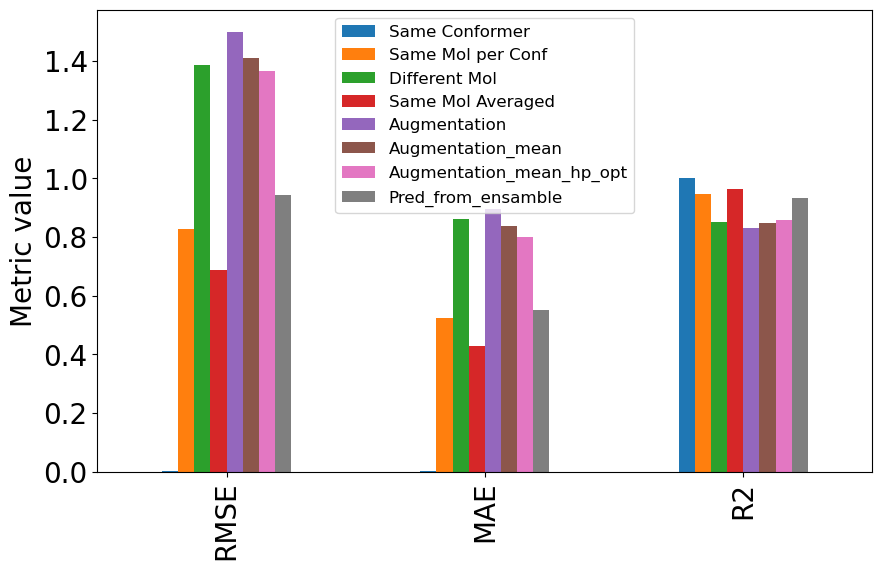

In [149]:
metric_df_different_mol = metric_df.iloc[:, 3:].copy()
print(f'Lowest RMSE: {metric_df_different_mol.iloc[0].idxmin(axis=0)}, {np.round(metric_df_different_mol.iloc[0].min(axis=0),2)}')
print(f'Lowest MAE: {metric_df_different_mol.iloc[1].idxmin(axis=0)}, {np.round(metric_df_different_mol.iloc[1].min(axis=0),2)}')
print(f'Highest R2: {metric_df_different_mol.iloc[2].idxmax(axis=0)}', np.round(metric_df_different_mol.iloc[2].max(axis=0),2))
#make barplot grouped by metric
metric_df.plot(kind='bar', figsize=(10,6), fontsize=20,ylabel='Metric value')
plt.ylabel('Metric value', fontsize=20)
plt.legend(fontsize=12)
plt.show()

## Train on 4 confs, pred 5th
This should be better then train on 1, pred other 4.

In [140]:
#get all molregnos from data_full that appear 5 or more times
molregnos = data_full['molregno'].value_counts()
molregnos = molregnos[molregnos == 6].index.tolist()
print(f'{len(molregnos)} molregnos with 6 conformers')
df_6_confs = data_full[data_full['molregno'].isin(molregnos)].copy()
#make another df with the rest of the data
#split data in six folds so that each fold has at least one conformer of each molregno
df_6_confs['fold'] = np.nan
for molregno in molregnos:
    #assign a fold to each conformer of this molregno
    df_6_confs.loc[df_6_confs['molregno'] == molregno, 'fold'] = np.arange(6)
df_6_confs['fold'] = df_6_confs['fold'].astype(int)
#check if each fold has at least one conformer of each molregno
for molregno in molregnos:
    if len(df_6_confs[df_6_confs['molregno'] == molregno]['fold'].unique()) != 6:
        print(f'molregno {molregno} not in each fold')
        break

1723 molregnos with 6 conformers


In [141]:
train_base = data_full[~data_full['molregno'].isin(molregnos)].copy()
for fold in range(6):
    #get all conformers of this fold
    df_fold = df_6_confs[df_6_confs['fold'] == fold].copy()
    #get all conformers of the other folds
    df_other_folds = df_6_confs[df_6_confs['fold'] != fold].copy()
    #add the conformers of the other folds to the train_base dataframe
    #first drop the fold column
    df_other_folds = df_other_folds.drop(columns=['fold'])
    #then add vertically to train_base
    train_base = pd.concat([train_base, df_other_folds], ignore_index=True)
    

    #get the mdfps and vps of the conformers for this fold
    test_x = np.array(df_fold['mdfp'].tolist())
    test_y = np.array(df_fold['vp'].tolist())
    train_x = np.array(train_base['mdfp'].tolist())
    train_y = np.array(train_base['vp'].tolist())

    #get molregnos test
    molregnos_test = df_fold['molregno'].tolist()
    #get confids test
    confids_test = df_fold['confid'].tolist()
   

    # Create DMatrix for training and testing
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dtest = xgb.DMatrix(test_x, label=test_y)
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=999,
        evals=[(dtest, "Test")],
        early_stopping_rounds=10,
        verbose_eval=False

    )
    pp = model.predict(dtest)

    output[0].append(test_y)
    output[1].append(pp)
    output[2].append(molregnos_test)
    output[3].append(confids_test)
    rmse = np.sqrt(mean_squared_error(test_y, pp,squared=False))
    print(f"Fold {fold + 1}: RMSE = {rmse}")

Fold 1: RMSE = 0.584013716255843
Fold 2: RMSE = 0.22878892658196207
Fold 3: RMSE = 0.17911618253937758
Fold 4: RMSE = 0.1623853479497816
Fold 5: RMSE = 0.15447271898606743
Fold 6: RMSE = 0.14804329116047515


RMSE:  0.943721988291164
MAE:  0.5507422465661161
R2:  0.9331219306898653


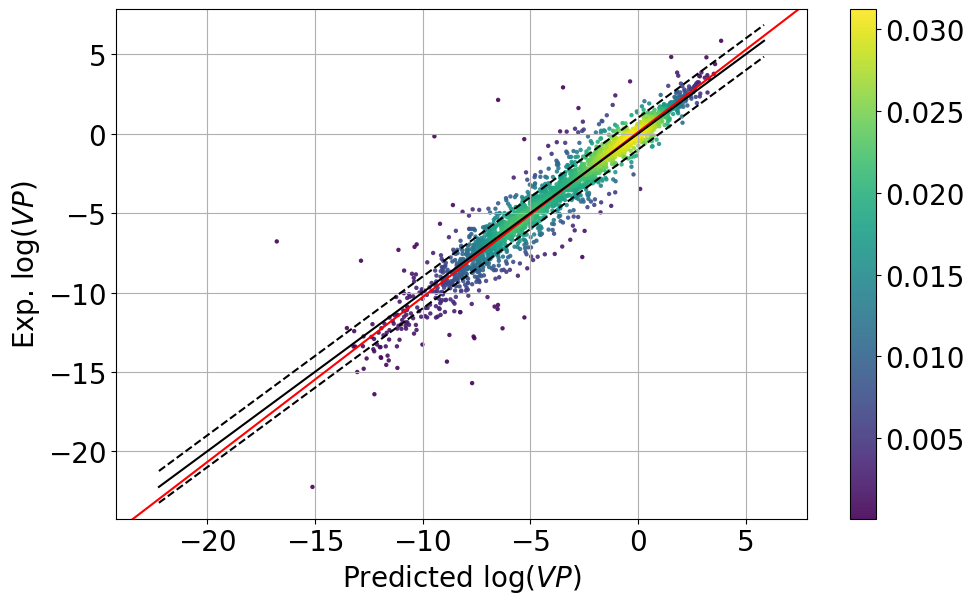

,Same Conformer,Same Mol per Conf,Different Mol,Same Mol Averaged,Augmentation,Augmentation_mean,Augmentation_mean_hp_opt,Pred_from_ensamble
RMSE,0.001999,0.828613,1.386804,0.686796,1.500263,1.409616,1.364706,0.943722
MAE,0.001351,0.524126,0.860514,0.429791,0.895319,0.837867,0.798393,0.550742
R2,1.000000,0.947605,0.852760,0.964007,0.829594,0.848282,0.857431,0.933122


In [142]:
vps = reduce(lambda a,b : list(a)+list(b) , output[0])
preds = reduce(lambda a,b : list(a)+list(b), output[1])
molregnos = reduce(lambda a,b : list(a)+list(b), output[2])
confids = reduce(lambda a,b : list(a)+list(b), output[3])
df_preds = pd.DataFrame({'vp': vps, 'pred': preds, 'confid': confids, 'molregno': molregnos})
df_preds = df_preds.groupby('molregno').mean()
prediction = df_preds['pred'].tolist()
real = df_preds['vp'].tolist()
density_plot(real,prediction)

slope_mdfp_d, intercept_mdfp_d, r2_fold, rmse_fold, mae_fold = getStatValues(prediction, real)
metric_df['Pred_from_ensamble'] = [rmse_fold, mae_fold, r2_fold]
metric_df

It is strange training on one conf and predicting the other 5 is easier then vice versa

## to investigate: diversit in RMSE over folds

In [143]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)
# Create an empty list to store the indices of each fold
fold_indices = []
# Group the data by 'molregno'
groups = data_full['molregno']
# Iterate over each fold
for train_idx, test_idx in gkf.split(data_full, groups=groups):
    fold_indices.append((train_idx, test_idx))


# Iterate over each fold
for fold, (train_idx, test_idx) in enumerate(fold_indices):
    # Split the data into train and test sets for this fold
    df_train = data_full.iloc[train_idx]
    df_test = data_full.iloc[test_idx]
    #get number of unique confids and molre3gnos
    n_train_confids = len(df_train['confid'].unique())
    n_test_confids = len(df_test['confid'].unique())
    n_train_molregnos = len(df_train['molregno'].unique())
    n_test_molregnos = len(df_test['molregno'].unique())
    #print out
    print(f'Fold {fold+1}:')
    print(f'\tNumber of training confids: {n_train_confids}')
    print(f'\tNumber of testing confids: {n_test_confids}')
    print(f'\tNumber of training molregnos: {n_train_molregnos}')
    print(f'\tNumber of testing molregnos: {n_test_molregnos}')
    #perfectly distributed


Fold 1:
	Number of training confids: 11372
	Number of testing confids: 2843
	Number of training molregnos: 2415
	Number of testing molregnos: 604
Fold 2:
	Number of training confids: 11372
	Number of testing confids: 2843
	Number of training molregnos: 2416
	Number of testing molregnos: 603
Fold 3:
	Number of training confids: 11372
	Number of testing confids: 2843
	Number of training molregnos: 2415
	Number of testing molregnos: 604
Fold 4:
	Number of training confids: 11372
	Number of testing confids: 2843
	Number of training molregnos: 2415
	Number of testing molregnos: 604
Fold 5:
	Number of training confids: 11372
	Number of testing confids: 2843
	Number of training molregnos: 2415
	Number of testing molregnos: 604


Not an issue of distribution

## General error sources

In [144]:
#lets get our best model so far that extrapolates to new mols
params = {
    'max_depth':9,
    'min_child_weight': 4,
    'eta':.05,
    'subsample': 1,
    'colsample_bytree': 0.5,
}
output = train_pred_xgboost(data_full,params)
vps = reduce(lambda a,b : list(a)+list(b) , output[0])
preds = reduce(lambda a,b : list(a)+list(b), output[1])
molregnos = reduce(lambda a,b : list(a)+list(b), output[2])
confids = reduce(lambda a,b : list(a)+list(b), output[3])

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 1: RMSE = 1.3434724334011732


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 2: RMSE = 1.1109512523742475


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 3: RMSE = 1.2110379137467717


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 4: RMSE = 1.1128012466692743


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 5: RMSE = 1.1884373175732792


now the spread actually does not look so big..

In [145]:
df_preds = pd.DataFrame({'vp': vps, 'pred': preds, 'confid': confids, 'molregno': molregnos})
#get mean and std per molregno
df_preds = df_preds.groupby('molregno').agg({'vp': ['mean'], 'pred': ['mean', 'std']})

#add column with absolute error between mean vp and mean pred
df_preds['abs_error'] = np.abs(df_preds['vp']['mean'] - df_preds['pred']['mean'])
df_preds = df_preds.sort_values(by=['abs_error'], ascending=False)
df_preds.head()


vp       pred            abs_error
               mean       mean       std           
molregno                                           
2342      -0.176128 -18.700890  0.965700  18.524761
3757     -22.229148  -8.025951  0.321616  14.203197
900      -14.346787  -4.169756  0.185708  10.177031
327       -6.786522 -16.763559  0.044174   9.977037
2821      -0.353596 -10.056642  0.080710   9.703045

In [146]:
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()
cur.execute("select * from conformers")
results = cur.fetchall()
#print columns
column_names = [desc[0] for desc in cur.description]
print(column_names)

print(f'{len(results)} results fetched')
#make dict with molregno as key and molblock as value
molregno_to_smiles = {}
for r in results:
    molblock = r[3]
    mol = Chem.MolFromMolBlock(molblock)
    smiles = Chem.MolToSmiles(mol)
    molregno_to_smiles[r[1]] = smiles
#add smiles to df
df_preds['SMILES'] = df_preds.index.map(molregno_to_smiles)
df_preds.head()

['conf_id', 'molregno', 'conformer_hash', 'molblock']
14455 results fetched


[15:27:08] Warning: molecule is tagged as 3D, but all Z coords are zero
[15:27:09] Warning: molecule is tagged as 3D, but all Z coords are zero
[15:27:09] Warning: molecule is tagged as 3D, but all Z coords are zero
[15:27:09] Warning: molecule is tagged as 3D, but all Z coords are zero
[15:27:09] Warning: molecule is tagged as 3D, but all Z coords are zero
[15:27:09] Warning: molecule is tagged as 3D, but all Z coords are zero
[15:27:09] Warning: molecule is tagged as 3D, but all Z coords are zero
[15:27:09] Warning: molecule is tagged as 3D, but all Z coords are zero


vp       pred            abs_error  \
               mean       mean       std              
molregno                                              
2342      -0.176128 -18.700890  0.965700  18.524761   
3757     -22.229148  -8.025951  0.321616  14.203197   
900      -14.346787  -4.169756  0.185708  10.177031   
327       -6.786522 -16.763559  0.044174   9.977037   
2821      -0.353596 -10.056642  0.080710   9.703045   

                                                     SMILES  
                                                             
molregno                                                     
2342      CC(C)(C)c1cc(Cn2c(=O)n(Cc3cc(C(C)(C)C)c(O)c(C(...  
3757      CCCC[C@H](CC)COC1=CC(=O)/C(=C2\N=C(c3ccc(OC)cc...  
900                              [NH3+]CCCCCCCCCCCC(=O)[O-]  
327       Cc1cc(C(C)(C)C)c(O)c(C)c1Cn1c(=O)n(Cc2c(C)cc(C...  
2821                 NS(=O)(=O)c1ccc(NC(=S)Nc2ccc(F)cc2)cc1

lets think about it. I think, considering similarity, there are two potentially interesting things to look at.
1. how similar are fingerprints of different starting conformers for the same molecule?
2. is there an impact of similarity to training set and performance metrics? And if so, could this explain the varying fold RMSE?

In [147]:
df_big_error = df_preds[df_preds['abs_error'] > 1]
print(f'{len(df_big_error)} mols with error > 1 log unit')
#sort by error
df_big_error = df_big_error.sort_values(by=['abs_error'], ascending=False)
#get mols, preds and real
SMILES = df_big_error['SMILES'].tolist()
mols = [Chem.MolFromSmiles(smi) for smi in SMILES]
preds = df_big_error['pred']['mean'].tolist()
real = df_big_error['vp']['mean'].tolist()
preds = [np.round(pred,2) for pred in preds]
real = [np.round(vp,2) for vp in real]
#draw the first 50
# Draw.MolsToGridImage(mols[:50], molsPerRow=1, subImgSize=(600, 600),legends=[f'Predicted: {pred}, Real: {real}' for pred, real in zip(preds[:50], real[:50])])

752 mols with error > 1 log unit


In [150]:
#look at mols with highest pred std
df_big_std = df_preds[df_preds['pred']['std'] > 0.5]
print(f'{len(df_big_std)} mols with pred std > 1 log unit')
#sort by std
df_big_std = df_big_std.sort_values(by=('pred','std'), ascending=False)
#get mols, preds and real
SMILES = df_big_std['SMILES'].tolist()
mols = [Chem.MolFromSmiles(smi) for smi in SMILES]
preds = df_big_std['pred']['mean'].tolist()
real = df_big_std['vp']['mean'].tolist()
preds = [np.round(pred,2) for pred in preds]
real = [np.round(vp,2) for vp in real]
stds = df_big_std['pred']['std'].tolist()
stds = [np.round(std,2) for std in stds]
#draw the first 50
# Draw.MolsToGridImage(mols[:50], molsPerRow=1, subImgSize=(600, 600),legends=[f'Predicted: {pred}, ({std}) Real: {real}' for pred, real,std in zip(preds[:50], real[:50],stds[:50])])




115 mols with pred std > 1 log unit


## Normalization
for input gives same result.
But maybe we can use normalization to compare similarity between fingerprints.


In [9]:
mdfps = data_full['mdfp'].tolist()
#scale mdfps
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance

scaler = StandardScaler()
mdfps = scaler.fit_transform(mdfps)
data_full['mdfp_scaled'] = mdfps.tolist()
molregnos_unique = data_full['molregno'].unique().tolist()
min_distances = []
for molregno in molregnos_unique:

    mrno_df = data_full[data_full['molregno'] == molregno]
    mdfps_scaled = mrno_df['mdfp_scaled'].tolist() 
    if len(mdfps_scaled) > 1:
        for scaled_mdfp in mdfps_scaled:
            distances = []
            for scaled_mdfp2 in mdfps_scaled:
                if scaled_mdfp != scaled_mdfp2:
                    euclidean_distance = distance.euclidean(scaled_mdfp, scaled_mdfp2)
                    distances.append(euclidean_distance)
            min_distances.append(min(distances))
    else:
        min_distances.append(0)
data_full['min_distance'] = min_distances


In [10]:
data_full

,confid,molregno,mdfp,vp,mdfp_scaled,min_distance
0,1150,7,"[9, 5, 0, 0, 0, 0, 0, 0, 0, 0, 7.3614322526332...",-0.301067,"[-0.6226549143008323, 0.2650253092002026, -0.5...",0.258072
1,1151,8,"[13, 1, 0, 2, 0, 0, 0, 0, 0, 0, -97.7987770071...",-6.053323,"[-0.03624823239482969, -0.6449679993174185, -0...",0.134939
2,2388,2390,"[10, 1, 0, 0, 0, 0, 0, 0, 0, 0, -24.3637634540...",-0.674795,"[-0.4760532438243316, -0.6449679993174185, -0....",0.156491
3,2400,2402,"[10, 2, 2, 0, 0, 0, 0, 0, 0, 0, -13.4724999801...",-3.000000,"[-0.4760532438243316, -0.41746967218801323, 1....",0.188197
4,2415,2417,"[15, 4, 1, 1, 0, 0, 1, 2, 0, 0, -174.933858069...",-4.700000,"[0.2569551085581716, 0.03752698207079733, 0.36...",0.134939
...,...,...,...,...,...,...
14211,15530,3539,"[44, 35, 2, 4, 0, 0, 0, 0, 0, 0, -285.66340740...",-7.000000,"[4.50840355237669, 7.089975123082361, 1.284691...",0.362739
14212,15531,3539,"[44, 35, 2, 4, 0, 0, 0, 0, 0, 0, -287.85335624...",-7.000000,"[4.50840355237669, 7.089975123082361, 1.284691...",0.125046
14213,15529,3539,"[44, 35, 2, 4, 0, 0, 0, 0, 0, 0, -286.74305751...",-7.000000,"[4.50840355237669, 7.089975123082361, 1.284691...",0.125046
14214,15532,3539,"[44, 35, 2, 4, 0, 0, 0, 0, 0, 0, -284.52836303...",-7.000000,"[4.50840355237669, 7.089975123082361, 1.284691...",0.321890
